# 综述
** 蓝色边缘程序使用高银纬SFD进行消光改正 **

我们需要实现的功能包含以下几点：

输入：
* csv星表**_的名字_**
* 需要画的色指数的两个测光点（比如 $ J - H $ 我们需要输入$J$ 和 $H$）


输出：
* 颜色-teff 图

Now,trying:
* 先判断银纬>30,点在颜色-teff图上看看分布，再去考虑怎么修正

# 数据的引入和format (Alternative)

In [120]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
%matplotlib inline

data_dir = '/Users/SY/Desktop/obic/data/'
#data_dir = '/Users/dengdingshan/Documents/data/obic/'

In [121]:
#read as pandas
starcatalog_fram = pd.read_csv(data_dir + 'lamost_bl_2mass.csv') 

###########

#starcatlog_fram = starcatlog_fram.ix[:,:517]
#print(starcatalog_fram)

In [122]:
## read Av for analyze the formula of Av ( by interpld )
catalog_Av = pd.read_csv(data_dir + 'A_AV.csv') 
catalog_Av = catalog_Av.sort_index(axis = 0,ascending = True,by = 'lamuda')
lamuda = catalog_Av['lamuda'].values
AAV = catalog_Av['AAV'].values
print(lamuda)

[ 3047  3372  3502  3546  3683  4127  4393  4404  4676  4690  4711  4814
  4861  4925  5244  5428  5479  5498  5519  6042  6335  6509  6571  6602
  6707  6993  7068  7799  7985  8046  8066  8090  8183  9055  9294 12660
 16732 22152 38079]


/Users/SY/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  This is separate from the ipykernel package so we can avoid doing imports until


In [123]:
f1=interp1d(lamuda,AAV,kind='cubic')#三次样条插值
x_pred=np.linspace(np.min(lamuda),np.max(lamuda),num=38079-3047+1)
y1=f1(x_pred)
a=np.where(x_pred==21700)
A_Ks=y1[a]
print(A_Ks)

[ 0.11552706]


In [124]:
### Elective CHOICE

########### I.
#change logTeff into Teff.

# def tenn(x):
#     y=10 ** x
#     return y

# Teff_tbl = starcatalog['logTeff'].apply(tenn)
###########

########### II.
#add [Teff] into DATAFRAME

#data_fram = starcatalog_fram[['TEFF_1','ERR_TEFF_1','Jmag_1','e_Jmag_1','Hmag_1','e_Hmag_1']]
#print(data_fram)
###########

########### III.
# fill the NaN blocks with 0

starcatalog_fram_fil0 = starcatalog_fram.fillna(0)

#print(starcatalog_fram_fil['LOGG'])
############


In [125]:
starcatalog_fram.columns

Index(['col1', 'Unnamed: 0', 'Unnamed: 0.1', 'TEFF', 'ERR_TEFF', 'RA', 'DEC',
       'LOGG', 'ERR_LOGG', 'FEH', 'ERR_FEH', 'SFD_ebv', 'l', 'b', '2MASS',
       'RAJ2000', 'DEJ2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag',
       'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X',
       'MeasureJD', 'angDist'],
      dtype='object')

In [126]:
catalog_Av.columns

Index(['lamuda', 'AAV'], dtype='object')

## 参数的选取（Input）

In [127]:
### variables

teff = 'TEFF'

color1 = 'Hmag'
color2 = 'Kmag'
err_teff = 'ERR_TEFF'

err_c1 = 'e_' + color1
#'e_' + color1
#color1 + 'err' 
#color1 + 'err'
#ERR_' + color1
#'e_' + color1

err_c2 = 'e_' + color2 
#'ERR_' + color2
#'e_' + color2

## Logg，误差的选取(Input:)

In [128]:
### we just need the mainsquence (dwarf stars)

# #judge logg >3.3 for avoid supergiants

Judge_logg = 3.0

starcatalog_fram_fil = starcatalog_fram_fil0[(starcatalog_fram_fil0['LOGG']> Judge_logg)]
#parsec_fram = parsec_fram[(parsec_fram['logg']>Judge_logg)]                                            

In [129]:
### get the good stars

# judge  data
starcatalog_fram_fil=starcatalog_fram_fil[((starcatalog_fram_fil[err_c1] != 0) \
                                          & (starcatalog_fram_fil[err_c2] != 0)\
                                          & (starcatalog_fram_fil[err_c1] != -99) \
                                          & (starcatalog_fram_fil[err_c2] != -99))\
                                         & ((starcatalog_fram_fil[color1] != 0)\
                                           & (starcatalog_fram_fil[color2] != 0)\
                                           & (starcatalog_fram_fil[color1] != -99) \
                                           & (starcatalog_fram_fil[color2] != -99))\
                                         &((starcatalog_fram_fil[err_c1] <=0.03))
                                          & ((starcatalog_fram_fil[err_c2] <=0.03))]
if (color1=='Jmag' or color2=='Jmag'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['Jmag'] >= 5.5)]
if (color1=='Hmag' or color2=='Hmag'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['Hmag'] >= 5)]  
if (color1=='Kmag' or color2=='Kmag'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['Kmag'] >= 4.5)]
if (color1=='W1mag' or color2=='W1mag'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['W1mag'] >= 8.1)]
if (color1=='W2mag' or color2=='W2mag'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['W2mag'] >= 6.7)]  
if (color1=='W3mag' or color2=='W3mag'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['W3mag'] >= 3.8)]
# starcatalog_fram_fil=starcatalog_fram_fil[((starcatalog_fram_fil['Jmag'] >= 5.5) \
#                                            &(starcatalog_fram_fil['Hmag'] >= 5)\
#                                            &(starcatalog_fram_fil['Kmag'] >= 4.5))\
#                                            &(starcatalog_fram_fil['W1mag'] >= 8.1) \
#                                            &(starcatalog_fram_fil['W2mag'] >= 6.7)\
#                                            &(starcatalog_fram_fil['W3mag'] >= 3.8))]
# # ### additional judgement

# starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil[err_c1] <=0.2)\
#                                            &(starcatalog_fram_fil[err_c2] <=0.05)]

# print(starcatalog_fram_fil.iloc[:,0].size)

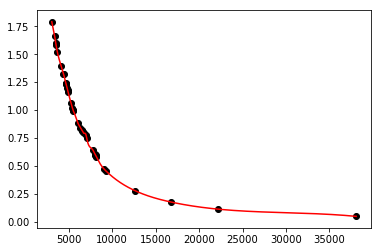

In [130]:
plt.figure(1)
plt.scatter(lamuda,AAV,c='black')
plt.plot(x_pred,y1,'r')
plt.show()

## 金属丰度的限制 (Input:)
$$ <0 $$
and 
$$ >0 $$

In [131]:
starcatalog_fram_fil=starcatalog_fram_fil[starcatalog_fram_fil['FEH'] > 0]

## 银纬的限制(Input:) 以及 SFD E(B-V)的限制(Input:)
b>30

In [132]:
starcatalog_fram_fil_b=starcatalog_fram_fil[starcatalog_fram_fil['b'] > 30]
starcatalog_fram_fil_b_Ebv=starcatalog_fram_fil_b[starcatalog_fram_fil_b['SFD_ebv'] < 0.05]

## 进行SFD修正
* 目前主要做到了SFD点的拟合

In [133]:
# # # Const1 = 0.709 #J #3.303 #g #2.285 #r 
# # # Const2 = 0.449 #H #2.285 #r #1.698 #i
# # ks=0.11552706

# SFD_catalog_color = []
# SFD_catalog_teff = []
# lens = len(starcatalog_fram_fil_b)

# for i in range(lens):    
#     SFD_colorindex = SFD_tbl_ratio[color1].values[i]\
#     - (SFD_tbl_ratio[color2].values[i])
#     SFD_catalog_color.append(SFD_colorindex)

#     SFD_catalog_teff.append(SFD_tbl_ratio[teff].values[i])
#     print(i)
# #     print(i)
# SFD_catalog_teff_fit = list(np.array(SFD_catalog_teff)/10000)
# # print(time.time() - time_start)

## 画图看分布

In [134]:
### figures & Savename
cc1 = 'H'
cc2 = 'Ks'

save = data_dir + 'pictures/'
# save = '/Users/SY/Desktop/obic/picture/'

i = datetime.datetime.now()
date_now = "%s_%s_%s_" % (i.year, i.month, i.day) 
ylabel = '$%s - %s$'%(cc1,cc2) 
savename1 = save + date_now + cc1 + cc2 + 'bl'+'.png'
savename2 = save + date_now + cc1 + '_HR_' + cc2 +'.png'
savename3 = save + date_now + 'errteff.png'

test = save + date_now + 'test.png'

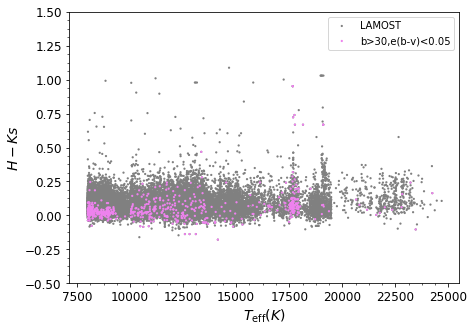

In [135]:
#PLT
ax = plt.figure(1,figsize=(7, 5))  
plt.xlabel('$T_\mathrm{eff}(K)$',fontsize=14)
plt.ylabel(ylabel,fontsize=14)

# the data we use
plt.scatter(starcatalog_fram_fil[teff], starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2],\
            c='grey',s=5, edgecolors='None',label='LAMOST')

# data we use in the SFD dustmap
plt.scatter(starcatalog_fram_fil_b_Ebv[teff],starcatalog_fram_fil_b_Ebv[color1]-starcatalog_fram_fil_b_Ebv[color2]\
            ,alpha=1,edgecolors='None',c='violet',s=5,label='b>30,e(b-v)<0.05',zorder=2)



plt.legend(loc='upper right')
#new_ticks = np.linspace(-1,2,7)
#plt.yticks(new_ticks)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig(savename1,dpi=200)
plt.minorticks_on()
plt.ylim(-0.5,1.5)
#plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1])
#plt.xlim(9000,25000)
plt.savefig(test,dpi=200)

plt.show()

## Try to get out the RA and DEC of these abnormal sources
* 26/10/2018 dds 通过肉眼瞅，暂时认为H-Ks>0都不可能是内禀色指数，那么就需要确认这些SFD和TEFF的关系

In [136]:
DF = starcatalog_fram_fil_b_Ebv
DF = DF[(DF[color1]-DF[color2]) > 0]
len(DF)

588

In [103]:
DF.to_csv(data_dir + 'Abnormal_LMwithSFD_new.csv')